In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(set(''.join(words)))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i: s for s, i in s_to_i.items()}
print(i_to_s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### build dataset

In [10]:
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words[:5]:
	context = [0] * block_size
	for ch in w + '.':
		ix = s_to_i[ch]
		X.append(context)
		Y.append(ix)
		if w == "emma": # first word
			print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix])
		context = context[1:] + [ix] # crop and append

print("X[2]", X[2])
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
X[2] [0, 5, 13]


In [7]:
X.shape, Y.shape # ["32", 3] because 32 is the number of 3 letter inputs

(torch.Size([32, 3]), torch.Size([32]))

In [8]:
C = torch.randn((27, 2)) # look up table

In [ ]:
print(C[0])
print(X[2]) # [0, 5, 13] <- ".em"
C[X][2] # same as C[[0, 5, 13]] because X[2] = [0, 5, 13]

tensor([-1.1643, -1.2915])
tensor([ 0,  5, 13])


tensor([[-1.1643, -1.2915],
        [ 1.2837, -0.0520],
        [-0.7215,  1.1557]])

## Forward pass

In [10]:
emb = C[X] # embeddings per character using indexing
emb.shape

torch.Size([32, 3, 2])

### hidden non linearity layer

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [13]:
h

tensor([[-0.9854,  0.8252,  0.6998,  ..., -0.9960,  0.9725, -0.9938],
        [ 0.8840,  0.2977,  0.6218,  ...,  0.7881, -0.9984, -0.9948],
        [ 0.9987, -0.9117,  1.0000,  ...,  0.9624, -0.6181, -1.0000],
        ...,
        [ 0.8687,  0.9629, -1.0000,  ..., -1.0000, -0.9505,  1.0000],
        [-1.0000, -0.9915, -1.0000,  ...,  0.9967, -0.9951,  0.7505],
        [-0.9037, -0.9937,  0.9844,  ...,  0.3856,  0.9731, -1.0000]])

In [14]:
h.shape

torch.Size([32, 100])

### output layer

In [15]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([32, 27])

In [18]:
counts = logits.exp()

In [19]:
probs = counts / counts.sum(1, keepdims=True)

### why cross_entropy instead of manual calculation of negative log likelihood 
1. much more efficient
   1. forward pass
   2. backward pass
2. numerically well behaved because manual exponentiation of large-ish numbers like 100 leads to an overflow if done manually, torch takes care of this internally

In [20]:
loss = F.cross_entropy(logits, Y)

In [21]:
loss

tensor(17.9401)

## train the NN

In [22]:
# build full dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words:
	context = [0] * block_size
	for ch in w + '.':
		ix = s_to_i[ch]
		X.append(context)
		Y.append(ix)
		context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [23]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # no. of parameters in total

3481

In [24]:
for p in parameters:
	p.requires_grad = True

In [25]:
# training on the ENTIRE dataset

for _ in range(10):
	# forward pass
	emb = C[X] # (228146, 3, 2)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y)
	print(loss.item())

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	for p in parameters:
		p.data += -0.1 * p.grad

17.555727005004883
16.10765838623047
15.113557815551758
14.230979919433594
13.48496150970459
12.863378524780273
12.31119441986084
11.807148933410645
11.3424711227417
10.912322998046875


### Choosing a suitable learning rate
We comb through all possible learning rates in a range. The min and max of this range are determined (for now) using trial and error.

Then we plot a graph of the learning rates and choose a point which is fairly stable but also where the model is able to "learn" (reduce loss) fairly quickly as well.

In [26]:
# resetting the parameters
C = torch.randn(27, 2)
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [27]:
for p in parameters:
	p.requires_grad = True

In [28]:
lre = torch.linspace(-3, 0, 500) # 500 evenly spaced numbers between -3 and 0
lrs = 10**lre # evenly -> exponentially spaced

In [29]:
# training on the SUBSET of the dataset
lri = []
lossi = []

for i in range(500):
	ix = torch.randint(0, X.shape[0], (32,))
	# forward pass
	emb = C[X[ix]] # (228146, 3, 2)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y[ix])

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = lrs[i]
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	lri.append(lre[i])
	lossi.append(loss.item())

# print(loss.item())


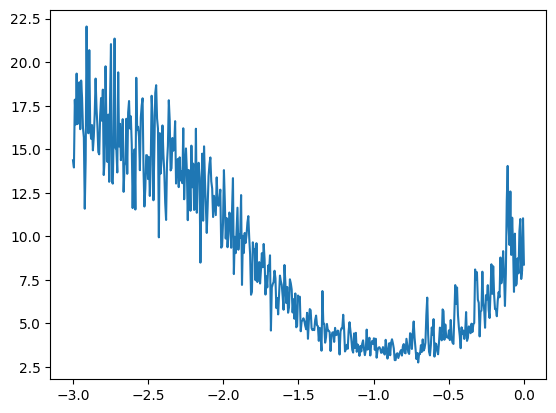

In [30]:
plt.plot(lri, lossi)
# the plot will show that a learning rate of about 10**-0.9=0.12
# is a good learning rate

### Notes
Always better to
- have an approximate vector (train over a smaller subset of the dataset) in the multi-dimensional space and train a lot of iterations _as opposed to_
- have an accurate vector (train over the entire dataset) in the multi-dimensional space and train for fewer iterations

In [31]:
# resetting the parameters
C = torch.randn(27, 2)
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
	p.requires_grad = True

### Notes
Once we observe that the learning rate is "stabilising", we will decay the learning rate, e.g., from `-0.12` to `-0.012`

In [32]:
# training on the SUBSET of the dataset

for _ in range(10000):
	ix = torch.randint(0, X.shape[0], (32,))
	# forward pass
	emb = C[X[ix]] # (228146, 3, 2)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y[ix])

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	for p in parameters:
		# p.data += -0.12 * p.grad
		p.data += -0.012 * p.grad

# print(loss.item())

In [33]:

print(loss.item())

2.297452688217163


## Training the NN again, this time with train, dev, and test splits

In [34]:
# build the dataset

def build_dataset(words):
	block_size = 3 # context length: how many characters do we take to predict the next one?

	X, Y = [], []
	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = s_to_i[ch]
			X.append(context)
			Y.append(ix)
			context = context[1:] + [ix] # crop and append

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

import random
random.seed(42)
random.shuffle(words)
print("words len", len(words))
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

words len 32033
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [35]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [36]:
# resetting the parameters
C = torch.randn(27, 2)
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [37]:
for p in parameters:
	p.requires_grad = True

In [38]:
# training on the SUBSET of the dataset

for i in range(10000):
	ix = torch.randint(0, Xtr.shape[0], (32,))
	# forward pass
	emb = C[Xtr[ix]] # (228146, 3, 2)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Ytr[ix])

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	for p in parameters:
		p.data += -0.12 * p.grad

print(loss.item())


2.578026294708252


### Notes
Evaluating and comparing the loss from both the training and dev set reveals that they are almost equal, which means that the model is underperforming ("underfitting" for the dataset) and performance improvements can be made

In [39]:
# Evaluate loss using training set

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5542, grad_fn=<NllLossBackward0>)

In [40]:
# Evaluate loss using dev set

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5505, grad_fn=<NllLossBackward0>)

### Increasing the number of neurons in the tanh (hidden) layer

In [41]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

10281

In [42]:
for p in parameters:
	p.requires_grad = True

In [52]:
# training on the SUBSET of the dataset
lri = []
lossi = []
stepi = []

for i in range(30000):
	ix = torch.randint(0, Xtr.shape[0], (32,))
	# forward pass
	emb = C[Xtr[ix]] # (228146, 3, 2)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Ytr[ix])

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	for p in parameters:
		p.data += -0.012 * p.grad

	# update stats
	stepi.append(i)
	lossi.append(loss.item())

print(loss.item())

2.0281636714935303


In [44]:
# plt.plot(stepi, lossi)

In [53]:
# Evaluate loss using dev set

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2561, grad_fn=<NllLossBackward0>)

In [54]:
# Evaluate loss using training set

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2480, grad_fn=<NllLossBackward0>)

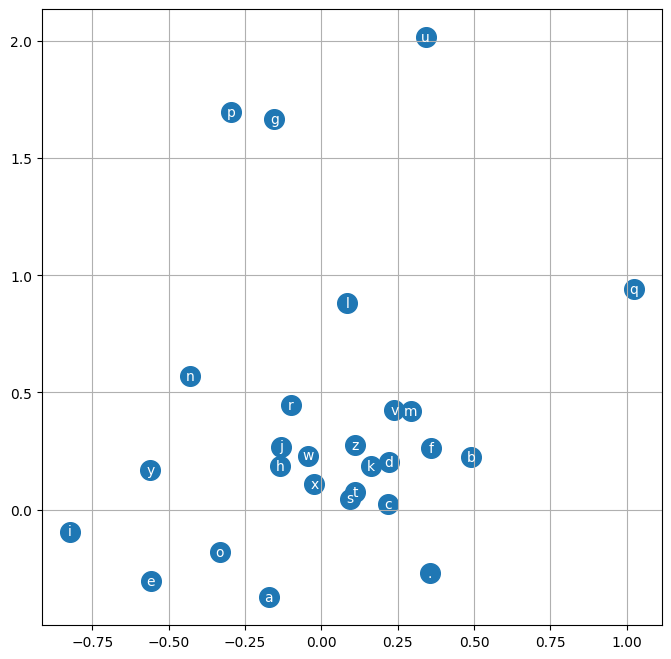

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
	plt.text(C[i, 0].item(), C[i, 1].item(), i_to_s[i], ha="center", va="center", color="white")
plt.grid("minor")

## Increasing the embedding space for vectors

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

11897

In [57]:
for p in parameters:
	p.requires_grad = True

In [58]:
lri = []
lossi = []
stepi = []

In [ ]:
# training on the SUBSET of the dataset

for i in range(50000):
	ix = torch.randint(0, Xtr.shape[0], (32,))
	# forward pass
	emb = C[Xtr[ix]] # (228146, 3, 2)
	h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Ytr[ix])

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	for p in parameters:
		p.data += -0.012 * p.grad

	# update stats
	stepi.append(i)
	lossi.append(loss.log10().item())

print(loss.item())

1.7707538604736328


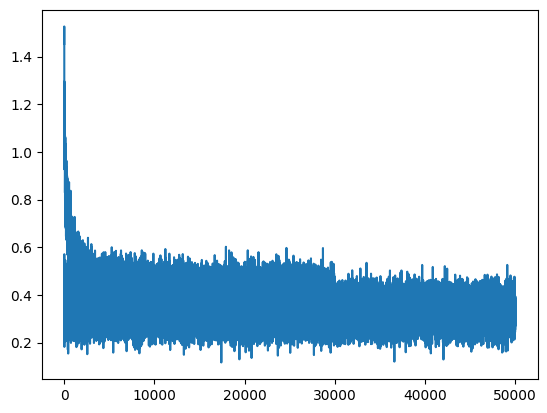

In [70]:
plt.plot(stepi, lossi)

In [71]:
# Evaluate loss using training set

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1696, grad_fn=<NllLossBackward0>)

In [72]:
# Evaluate loss using dev set

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2037, grad_fn=<NllLossBackward0>)

## Sample from the model

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
	out = []
	context = [0] * block_size # initialize with all ...
	while True:
		emb = C[torch.tensor([context])]
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1, generator=g).item()
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break

	print(''.join(i_to_s[i] for i in out))

carlah.
amelle.
khi.
mri.
reith.
skandane.
rahnevalee.
rha.
kaqui.
neronia.
chaiivia.
legg.
hham.
jorn.
quinthanlin.
alianni.
waveloniearynix.
kaeliighan.
edde.
oia.


## Improving loss
1. Increase context length to 4
2. Increase embedding dimension to 15
3. Train for 100K steps using learning rate decay
4. Increase batch size from 32 to 64
5. Use ReLU instead of tanh

In [85]:
# Configuration
block_size = 4 # number of letters in context
emb_dim = 15
batch_size = 64

In [86]:
# Rebuild the dataset with new block_size
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [89]:
# Initialization
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((block_size * emb_dim, 200), generator=g)
b1 = torch.randn(200)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [97]:
# training on the SUBSET of the dataset

for i in range(200000):
	ix = torch.randint(0, Xtr.shape[0], (batch_size,))
	# forward pass
	emb = C[Xtr[ix]]
	h = torch.relu(emb.view(-1, block_size * emb_dim) @ W1 + b1)
	logits = h @ W2 + b2
	loss = F.cross_entropy(logits, Ytr[ix])

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# Learning rate with decay
	lr = 0.12 if i < 150000 else 0.012

	# update
	for p in parameters:
		p.data += -lr * p.grad

	# update stats
	stepi.append(i)
	lossi.append(loss.log10().item())

print(loss.item())

2.002702236175537


In [98]:
# Evaluate loss using training set

emb = C[Xtr]
h = torch.relu(emb.view(-1, block_size * emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1075, grad_fn=<NllLossBackward0>)

In [99]:
# Evaluate loss using dev set

emb = C[Xdev]
h = torch.relu(emb.view(-1, block_size * emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1380, grad_fn=<NllLossBackward0>)

In [96]:
# USE SPARINGLY
# Evaluate loss using test set

emb = C[Xte]
h = torch.relu(emb.view(-1, block_size * emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1657, grad_fn=<NllLossBackward0>)

## Sample from the improved model

In [100]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
	out = []
	context = [0] * block_size # initialize with all ...
	while True:
		emb = C[torch.tensor([context])]
		h = torch.relu(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1, generator=g).item()
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break

	print(''.join(i_to_s[i] for i in out))

carlah.
amillie.
hirmy.
xhea.
cahland.
kejrahnen.
deliah.
jareeigne.
mara.
chaiir.
kaleigh.
hama.
kinder.
juzarlen.
aliven.
corae.
madearyn.
kakhen.
dusan.
edde.
